In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 2. Convenience Functions


### 2.1 Masked Softmax Operation


In [2]:
def masked_softmax(X: torch.tensor, valid_lens: torch.tensor):
    """Computes a modified softmax operation on a given input tensor X while considering the valid lengths of sequences.

    Args:
        X (torch.tensor): shape: (batch_size, query_dim, key_dim)
        valid_lens (torch.tensor): 
            1. When `valid_lens` is a 1D tensor:
                `valid_lens.shape` is `(batch_size, )`
                
            2. When `valid_lens` has more than 1 dimension:
                `valid_lens.shape` is `(batch_size, num_conditions)`
    """
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = _sequence_mask(
            X.reshape(-1, shape[-1]), valid_lens,
            value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5308, 0.4692, 0.0000, 0.0000],
         [0.4989, 0.5011, 0.0000, 0.0000]],

        [[0.2923, 0.3411, 0.3666, 0.0000],
         [0.2549, 0.3021, 0.4430, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4),
               torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4429, 0.3530, 0.2041, 0.0000]],

        [[0.4574, 0.5426, 0.0000, 0.0000],
         [0.1868, 0.3045, 0.2945, 0.2142]]])

### 2.2 Batch Matrix Multiplication


\begin{split}\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n] \in \mathbb{R}^{n \times a \times b}, \\
\mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n] \in \mathbb{R}^{n \times b \times c}.\end{split}


\begin{split}\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.\end{split}

In [5]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
print(torch.bmm(Q, K).shape == (2, 3, 6))

True


## 3. Additive Attention


\begin{split} a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}, \end{split}


In [6]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [7]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))

valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[-0.0610,  0.4311,  0.0671,  0.3003]],

        [[ 0.1656, -0.6730, -0.0854, -0.2545]]], grad_fn=<BmmBackward0>)

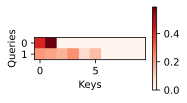

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),  xlabel='Keys', ylabel='Queries')

## 4. Scaled Dot Product Attention


\begin{split} \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}. \end{split}

In [9]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2) / math.sqrt(d))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [10]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[-0.6379,  0.3360,  1.0597,  0.5396]],

        [[ 0.0426, -0.5953, -0.2381,  0.0306]]])

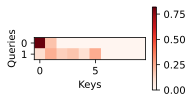

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')